Comparison: Stepping-Out vs Doubling

STEPPING-OUT Method:
------------------------------
Generated 1000/5500 samples
Generated 2000/5500 samples
Generated 3000/5500 samples
Generated 4000/5500 samples
Generated 5000/5500 samples

Method: stepping-out
Total log_pdf evaluations: 38609
Evaluations per sample: 7.02

DOUBLING Method:
------------------------------
Generated 1000/5500 samples
Generated 2000/5500 samples
Generated 3000/5500 samples
Generated 4000/5500 samples
Generated 5000/5500 samples

Method: doubling
Total log_pdf evaluations: 60931
Evaluations per sample: 11.08


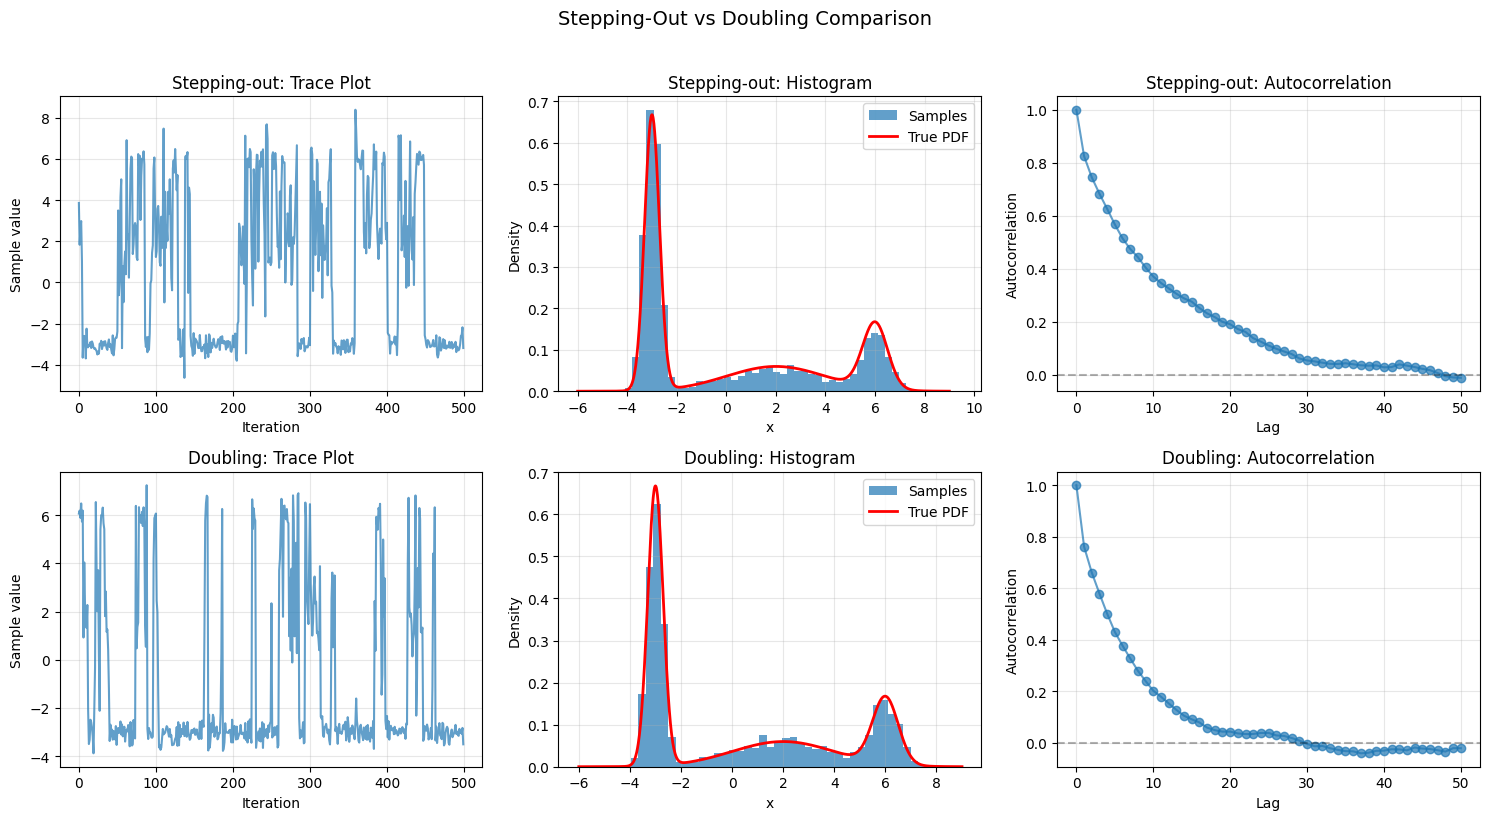


PERFORMANCE COMPARISON

STEPPING-OUT:
  Evaluations per sample: 7.02
  Mean: -0.080
  Std: 3.701
  Effective Sample Size: 240 (4.8%)

DOUBLING:
  Evaluations per sample: 11.08
  Mean: 0.276
  Std: 3.746
  Effective Sample Size: 412 (8.2%)

Test: Doubling on Exponential Distribution

Testing stepping-out...
Generated 1000/3200 samples
Generated 2000/3200 samples
Generated 3000/3200 samples

Method: stepping-out
Total log_pdf evaluations: 20452
Evaluations per sample: 6.39
  Sample mean: 0.4886 (true: 0.5000)
  Sample var: 0.2409 (true: 0.2500)
  Evaluations per sample: 6.39

Testing doubling...
Generated 1000/3200 samples
Generated 2000/3200 samples
Generated 3000/3200 samples

Method: doubling
Total log_pdf evaluations: 34507
Evaluations per sample: 10.78
  Sample mean: 0.4919 (true: 0.5000)
  Sample var: 0.2616 (true: 0.2500)
  Evaluations per sample: 10.78


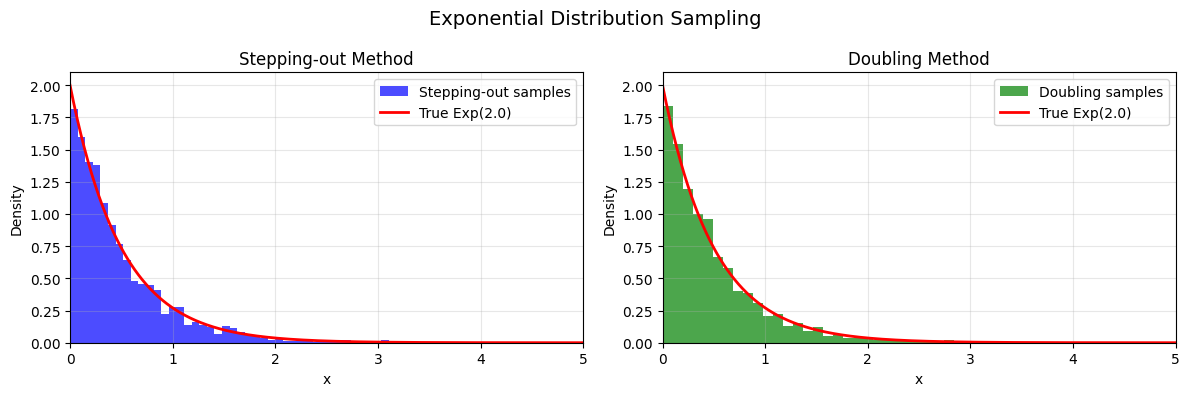


Enhanced Slice Sampler with Doubling Complete!


In [ ]:
from typing import Callable, Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


class SliceSampler:
    """
    Slice Sampler for 1D distributions using either stepping-out or doubling procedures.

    Reference: Neal, R. M. (2003). Slice sampling. Annals of statistics, 705-767.
    https://doi.org/10.1214/aos/1056562461
    """

    def __init__(
        self,
        log_pdf: Callable[[float], float],
        w: float = 1.0,
        m: int = 100,
        method: Literal["stepping-out", "doubling"] = "stepping-out",
        verbose: bool = False,
    ):
        """
        Initialize the Slice Sampler.

        Parameters:
        -----------
        log_pdf : Callable
            Log probability density function (or unnormalized log density)
        w : float
            Initial width of the slice interval (step size for stepping out/doubling)
        m : int
            For stepping-out: max number of steps
            For doubling: max number of doublings (interval can expand by 2^m)
        method : str
            Either 'stepping-out' or 'doubling' to choose interval finding method
        verbose : bool
            If True, print debugging information
        """
        self.log_pdf = log_pdf
        self.w = w
        self.m = m
        self.method = method
        self.verbose = verbose
        self.n_evals = 0  # Track number of log_pdf evaluations

    def _eval_log_pdf(self, x: float) -> float:
        """Wrapper to count evaluations of log_pdf."""
        self.n_evals += 1
        return self.log_pdf(x)

    def stepping_out(self, x0: float, log_y: float) -> Tuple[float, float]:
        """
        Find an interval around x0 using the stepping-out procedure.

        Parameters:
        -----------
        x0 : float
            Current position
        log_y : float
            Log height of the horizontal slice

        Returns:
        --------
        (L, R) : tuple
            Left and right boundaries of the interval
        """
        # Random initial interval around x0
        u = np.random.uniform()
        L = x0 - self.w * u
        R = L + self.w

        # Randomly allocate the maximum number of steps to left and right
        j = np.floor(self.m * np.random.uniform())
        k = (self.m - 1) - j

        # Step out to the left
        while j > 0 and self._eval_log_pdf(L) > log_y:
            L = L - self.w
            j = j - 1

        # Step out to the right
        while k > 0 and self._eval_log_pdf(R) > log_y:
            R = R + self.w
            k = k - 1

        if self.verbose:
            print(f"Stepping out: interval = [{L:.4f}, {R:.4f}]")

        return L, R

    def doubling(self, x0: float, log_y: float) -> Tuple[float, float]:
        """
        Find an interval around x0 using the doubling procedure.

        Parameters:
        -----------
        x0 : float
            Current position
        log_y : float
            Log height of the horizontal slice

        Returns:
        --------
        (L, R) : tuple
            Left and right boundaries of the interval
        """
        # Random initial interval around x0
        u = np.random.uniform()
        L = x0 - self.w * u
        R = L + self.w

        # Keep track of how many times we've doubled
        k = self.m

        # Double the interval until both ends are outside the slice
        # or we've reached the maximum number of doublings
        while k > 0 and (
            self._eval_log_pdf(L) > log_y or self._eval_log_pdf(R) > log_y
        ):
            # Randomly double to the left or right
            if np.random.uniform() < 0.5:
                L = L - (R - L)
            else:
                R = R + (R - L)
            k = k - 1

        if self.verbose:
            print(
                f"Doubling: interval = [{L:.4f}, {R:.4f}], doublings used = {self.m - k}"
            )

        return L, R

    def accept_doubling(
        self, x0: float, x1: float, log_y: float, L: float, R: float
    ) -> bool:
        """
        Acceptance test for the doubling procedure (Figure 6 from Neal's paper).
        This test ensures detailed balance when using doubling.

        Parameters:
        -----------
        x0 : float
            Current position
        x1 : float
            Proposed new position
        log_y : float
            Log height of the horizontal slice
        L : float
            Left boundary of interval
        R : float
            Right boundary of interval

        Returns:
        --------
        accept : bool
            Whether to accept the proposed point
        """
        # The interval that could have been produced when proposing x1
        L_hat = L
        R_hat = R
        D = False  # Flag to track if we've started shrinking

        while (R_hat - L_hat) > 1.1 * self.w:  # Numerical tolerance
            # Find midpoint
            M = (L_hat + R_hat) / 2.0

            if (x0 < M and x1 >= M) or (x0 >= M and x1 < M):
                D = True

            if x1 < M:
                R_hat = M
            else:
                L_hat = M

            # Accept if the interval that would have been created when proposing
            # x1 from x0 has both ends outside the slice
            if (
                D
                and self._eval_log_pdf(L_hat) <= log_y
                and self._eval_log_pdf(R_hat) <= log_y
            ):
                return False

        return True

    def shrinkage(self, x0: float, log_y: float, L: float, R: float) -> float:
        """
        Sample from the interval [L, R] using the shrinkage procedure.
        Used with stepping-out method.

        Parameters:
        -----------
        x0 : float
            Current position
        log_y : float
            Log height of the horizontal slice
        L : float
            Left boundary of interval
        R : float
            Right boundary of interval

        Returns:
        --------
        x1 : float
            New sample from the slice
        """
        while True:
            # Sample uniformly from [L, R]
            x1 = np.random.uniform(L, R)

            # Accept if x1 is on the slice
            if self._eval_log_pdf(x1) > log_y:
                if self.verbose:
                    print(f"Shrinkage: accepted x1 = {x1:.4f}")
                return x1

            # Shrink the interval
            if x1 < x0:
                L = x1
            else:
                R = x1

            if self.verbose:
                print(f"Shrinkage: interval shrunk to [{L:.4f}, {R:.4f}]")

            # Safety check to avoid infinite loop
            if R - L < 1e-10:
                if self.verbose:
                    print("Warning: Interval too small, returning midpoint")
                return (L + R) / 2

    def sample_from_interval_doubling(
        self, x0: float, log_y: float, L: float, R: float
    ) -> float:
        """
        Sample from the interval [L, R] using the acceptance test for doubling.

        Parameters:
        -----------
        x0 : float
            Current position
        log_y : float
            Log height of the horizontal slice
        L : float
            Left boundary of interval
        R : float
            Right boundary of interval

        Returns:
        --------
        x1 : float
            New sample from the slice
        """
        while True:
            # Sample uniformly from [L, R]
            x1 = np.random.uniform(L, R)

            # Check if x1 is on the slice
            if self._eval_log_pdf(x1) <= log_y:
                # Not on slice, shrink interval (same as regular shrinkage)
                if x1 < x0:
                    L = x1
                else:
                    R = x1

                if self.verbose:
                    print(f"Doubling sampler: interval shrunk to [{L:.4f}, {R:.4f}]")

                # Safety check
                if R - L < 1e-10:
                    if self.verbose:
                        print("Warning: Interval too small, returning midpoint")
                    return (L + R) / 2
            else:
                # x1 is on the slice, but need to check acceptance test
                if self.accept_doubling(x0, x1, log_y, L, R):
                    if self.verbose:
                        print(f"Doubling sampler: accepted x1 = {x1:.4f}")
                    return x1
                else:
                    # Failed acceptance test, shrink interval
                    if x1 < x0:
                        L = x1
                    else:
                        R = x1

                    if self.verbose:
                        print(
                            f"Doubling sampler: failed acceptance test, shrunk to [{L:.4f}, {R:.4f}]"
                        )

    def sample_one(self, x0: float) -> float:
        """
        Generate one sample using slice sampling.

        Parameters:
        -----------
        x0 : float
            Current position

        Returns:
        --------
        x1 : float
            New sample
        """
        # Step 1: Sample auxiliary variable (height of the slice)
        # see page 711 of Neal's paper for explanation of exponential(1)
        # and log space
        log_y = self._eval_log_pdf(x0) - np.random.exponential(1)

        # Step 2: Find interval using chosen method
        if self.method == "stepping-out":
            L, R = self.stepping_out(x0, log_y)
            # Step 3: Sample from interval using shrinkage
            x1 = self.shrinkage(x0, log_y, L, R)
        elif self.method == "doubling":
            L, R = self.doubling(x0, log_y)
            # Step 3: Sample from interval using doubling acceptance test
            x1 = self.sample_from_interval_doubling(x0, log_y, L, R)
        else:
            raise ValueError(f"Unknown method: {self.method}")

        return x1

    def sample(
        self, x0: float, n_samples: int, burn_in: int = 0, thin: int = 1
    ) -> np.ndarray:
        """
        Generate multiple samples using slice sampling.

        Parameters:
        -----------
        x0 : float
            Initial position
        n_samples : int
            Number of samples to generate (after burn-in and thinning)
        burn_in : int
            Number of initial samples to discard
        thin : int
            Keep every thin-th sample

        Returns:
        --------
        samples : np.ndarray
            Array of samples
        """
        self.n_evals = 0
        total_samples = burn_in + n_samples * thin
        all_samples = np.zeros(total_samples)

        # Generate all samples
        x = x0
        for i in range(total_samples):
            x = self.sample_one(x)
            all_samples[i] = x

            if (i + 1) % 1000 == 0:
                print(f"Generated {i + 1}/{total_samples} samples")

        # Apply burn-in and thinning
        samples = all_samples[burn_in::thin]

        print(f"\nMethod: {self.method}")
        print(f"Total log_pdf evaluations: {self.n_evals}")
        print(f"Evaluations per sample: {self.n_evals / total_samples:.2f}")

        return samples


def compare_methods():
    """Compare stepping-out vs doubling procedures on different distributions."""
    print("=" * 60)
    print("Comparison: Stepping-Out vs Doubling")
    print("=" * 60)

    # Test distribution: Mixture of Gaussians with different scales
    def log_pdf(x):
        # Mixture with narrow and wide components
        p1 = 0.5 * stats.norm.pdf(x, -3, 0.3)
        p2 = 0.3 * stats.norm.pdf(x, 2, 2.0)
        p3 = 0.2 * stats.norm.pdf(x, 6, 0.5)
        return np.log(p1 + p2 + p3 + 1e-10)

    n_samples = 5000
    burn_in = 500

    # Test both methods
    methods = ["stepping-out", "doubling"]
    results = {}

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for i, method in enumerate(methods):
        print(f"\n{method.upper()} Method:")
        print("-" * 30)

        sampler = SliceSampler(log_pdf, w=1.5, m=50, method=method)
        samples = sampler.sample(x0=0.0, n_samples=n_samples, burn_in=burn_in, thin=1)

        results[method] = {
            "samples": samples,
            "evals_per_sample": sampler.n_evals / (n_samples + burn_in),
        }

        # Trace plot
        axes[i, 0].plot(samples[:500], alpha=0.7)
        axes[i, 0].set_title(f"{method.capitalize()}: Trace Plot")
        axes[i, 0].set_xlabel("Iteration")
        axes[i, 0].set_ylabel("Sample value")
        axes[i, 0].grid(True, alpha=0.3)

        # Histogram
        x_range = np.linspace(-6, 9, 1000)
        true_pdf = (
            0.5 * stats.norm.pdf(x_range, -3, 0.3)
            + 0.3 * stats.norm.pdf(x_range, 2, 2.0)
            + 0.2 * stats.norm.pdf(x_range, 6, 0.5)
        )

        axes[i, 1].hist(samples, bins=50, density=True, alpha=0.7, label="Samples")
        axes[i, 1].plot(x_range, true_pdf, "r-", linewidth=2, label="True PDF")
        axes[i, 1].set_title(f"{method.capitalize()}: Histogram")
        axes[i, 1].set_xlabel("x")
        axes[i, 1].set_ylabel("Density")
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

        # Autocorrelation
        from statsmodels.tsa.stattools import acf

        autocorr = acf(samples, nlags=50)
        axes[i, 2].plot(autocorr, "o-", alpha=0.7)
        axes[i, 2].axhline(y=0, color="k", linestyle="--", alpha=0.3)
        axes[i, 2].set_title(f"{method.capitalize()}: Autocorrelation")
        axes[i, 2].set_xlabel("Lag")
        axes[i, 2].set_ylabel("Autocorrelation")
        axes[i, 2].grid(True, alpha=0.3)

    plt.suptitle("Stepping-Out vs Doubling Comparison", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print("\n" + "=" * 60)
    print("PERFORMANCE COMPARISON")
    print("=" * 60)

    for method in methods:
        print(f"\n{method.upper()}:")
        print(f"  Evaluations per sample: {results[method]['evals_per_sample']:.2f}")
        print(f"  Mean: {np.mean(results[method]['samples']):.3f}")
        print(f"  Std: {np.std(results[method]['samples']):.3f}")

        # Effective sample size (based on autocorrelation)
        from statsmodels.tsa.stattools import acf

        autocorr = acf(results[method]["samples"], nlags=100, fft=True)
        # Find first negative autocorrelation
        first_negative = np.where(autocorr < 0)[0]
        if len(first_negative) > 0:
            sum_autocorr = 1 + 2 * np.sum(autocorr[1 : first_negative[0]])
        else:
            sum_autocorr = 1 + 2 * np.sum(autocorr[1:])
        ess = n_samples / sum_autocorr
        print(f"  Effective Sample Size: {ess:.0f} ({ess / n_samples * 100:.1f}%)")


def test_doubling_on_exponential():
    """Test the doubling procedure on an exponential distribution."""
    print("\n" + "=" * 60)
    print("Test: Doubling on Exponential Distribution")
    print("=" * 60)

    # Exponential distribution (challenging for slice sampling due to heavy tail)
    rate = 2.0

    def log_pdf(x):
        if x < 0:
            return -np.inf
        return -rate * x

    # Test both methods
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for i, (method, w_val) in enumerate([("stepping-out", 0.5), ("doubling", 0.5)]):
        print(f"\nTesting {method}...")
        sampler = SliceSampler(log_pdf, w=w_val, m=30, method=method, verbose=False)
        samples = sampler.sample(x0=1.0, n_samples=3000, burn_in=200, thin=1)

        # Compare with true exponential
        x_range = np.linspace(0, 5, 1000)
        true_pdf = rate * np.exp(-rate * x_range)

        axes[i].hist(
            samples,
            bins=50,
            density=True,
            alpha=0.7,
            color="blue" if method == "stepping-out" else "green",
            label=f"{method.capitalize()} samples",
        )
        axes[i].plot(x_range, true_pdf, "r-", linewidth=2, label=f"True Exp({rate})")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("Density")
        axes[i].set_title(f"{method.capitalize()} Method")
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, 5)

        # Print statistics
        true_mean = 1 / rate
        true_var = 1 / rate**2
        print(f"  Sample mean: {np.mean(samples):.4f} (true: {true_mean:.4f})")
        print(f"  Sample var: {np.var(samples):.4f} (true: {true_var:.4f})")
        print(f"  Evaluations per sample: {sampler.n_evals / 3200:.2f}")

    plt.suptitle("Exponential Distribution Sampling", fontsize=14)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Run comparison
    compare_methods()

    # Test on exponential (a challenging case for slice sampling)
    test_doubling_on_exponential()

    print("\n" + "=" * 60)
    print("Enhanced Slice Sampler with Doubling Complete!")
    print("=" * 60)